# ERROR <br>
## end-to-end (U-Net - ResNet 50)

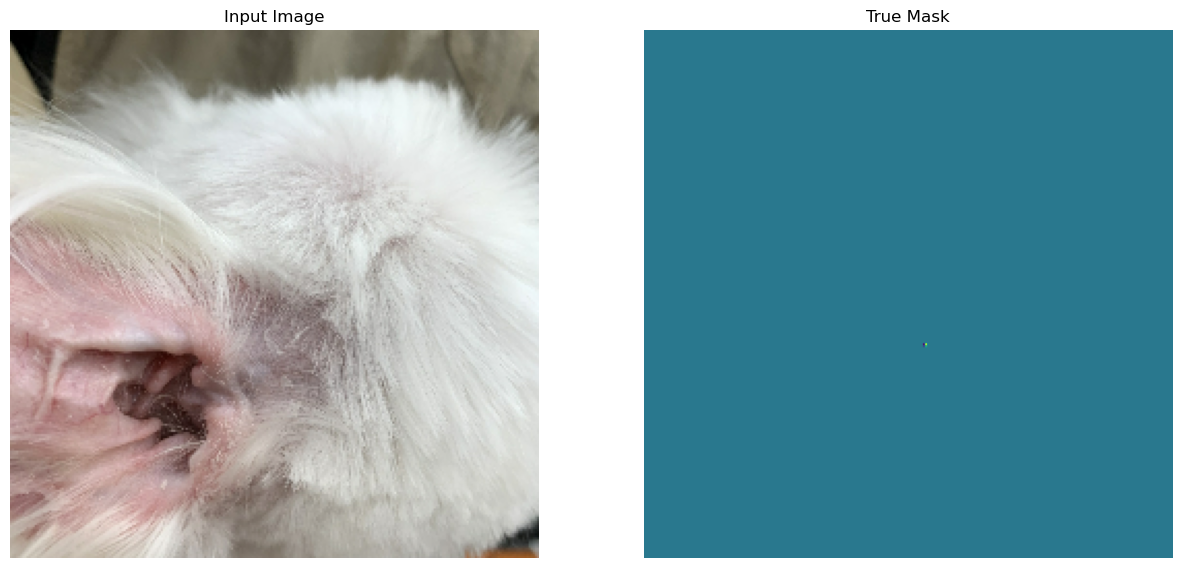

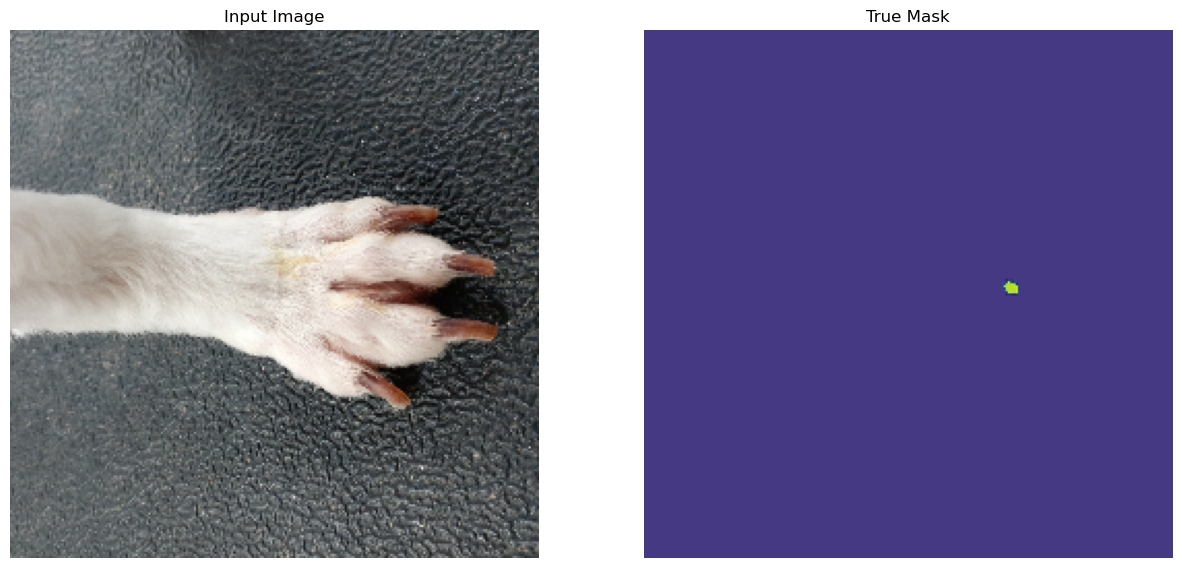

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import keras_tuner as kt

# 데이터 로드 함수 정의
def parse_tfrecord_fn(example):
    feature_description = {
        'Raw_data_ID': tf.io.FixedLenFeature([], tf.string),
        'img_path': tf.io.FixedLenFeature([], tf.string),
        'lesions': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    img_path = tf.strings.join([example['img_path'], tf.constant('/'), example['Raw_data_ID']])
    lesions = tf.strings.split(example['lesions'], ',')  # Split the lesions string

    # channel = 3 (RGB)
    img = tf.io.decode_png(tf.io.read_file(img_path), channels=3)

    # Create mask paths using tf.map_fn
    mask_paths = tf.map_fn(lambda lesion: tf.strings.regex_replace(img_path, 'images', f'train_true_mask_images_{lesion}'), lesions, dtype=tf.string)
    mask_paths = tf.strings.join(['./train_true_mask_images_', lesions, '/mask_', example['Raw_data_ID']])

    # Read and decode masks
    masks = tf.map_fn(lambda mask_path: tf.io.decode_png(tf.io.read_file(mask_path), channels=1), mask_paths, dtype=tf.uint8)

    # Combine masks into a single mask (assuming multiple lesions)
    combined_mask = tf.reduce_max(masks, axis=0)  # Combine masks by taking the maximum value at each pixel

    return img, combined_mask

# TFRecord 파일 리스트
tfrecord_files = './train_symptoms_tfrecords/train_symptoms_A1.tfrecord'
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(parse_tfrecord_fn)

# 데이터셋 준비 함수
def prepare_dataset(dataset, batch_size=2, target_size=(256, 256)):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # 이미지 크기 조정
    def resize_image(image, mask):
        image = tf.image.resize(image, target_size)
        mask = tf.image.resize(mask, target_size, method='nearest')  # nearest neighbor interpolation 사용하여 마스크 크기 조정
        mask = tf.cast(mask, tf.float32) / 255.0  # 데이터 형식 변환 및 정규화
        mask = tf.expand_dims(mask, axis=-1)  # 마스크의 채널 축 추가 (image와 일치)
        return image, mask

    dataset = dataset.map(resize_image)
    
    return dataset

# 100개의 샘플링 및 데이터셋 준비
sampled_dataset = dataset.take(100)
train_dataset = prepare_dataset(sampled_dataset)

# 데이터셋 시각화
def display_sample(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i][0]))  # 배치 차원 제거
        else:
            mask = tf.squeeze(display_list[i][0], axis=-1)  # 배치 차원 제거 및 마스크의 채널 축 제거
            plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
        plt.axis('off')
    plt.show()

for image, mask in train_dataset.take(2):
    sample_image, sample_mask = image[0][tf.newaxis, ...], mask[0][tf.newaxis, ...]
    display_sample([sample_image, sample_mask])


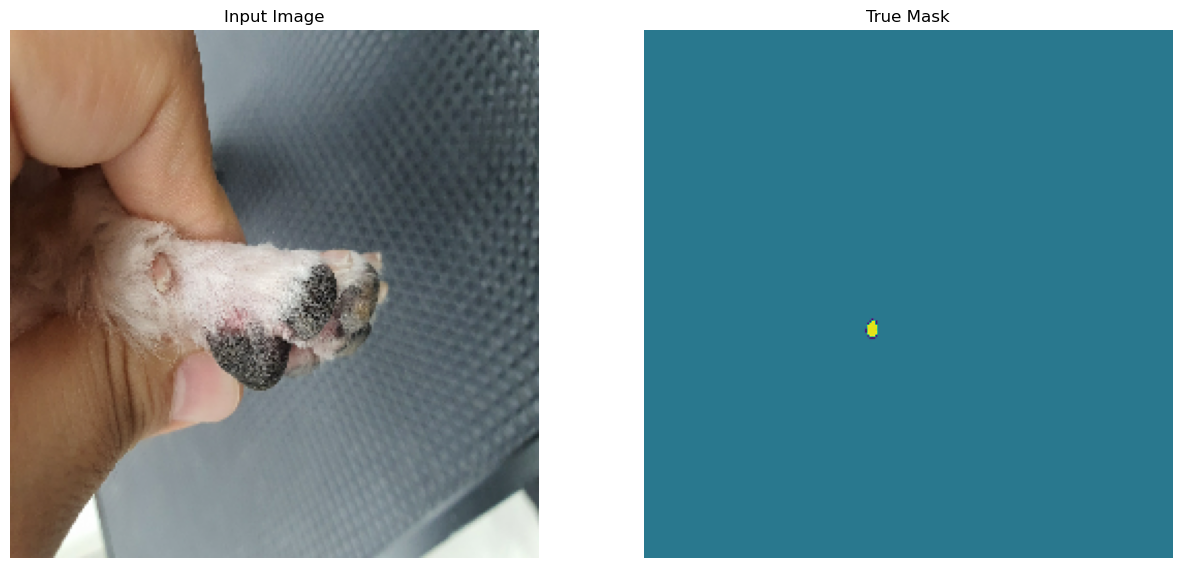

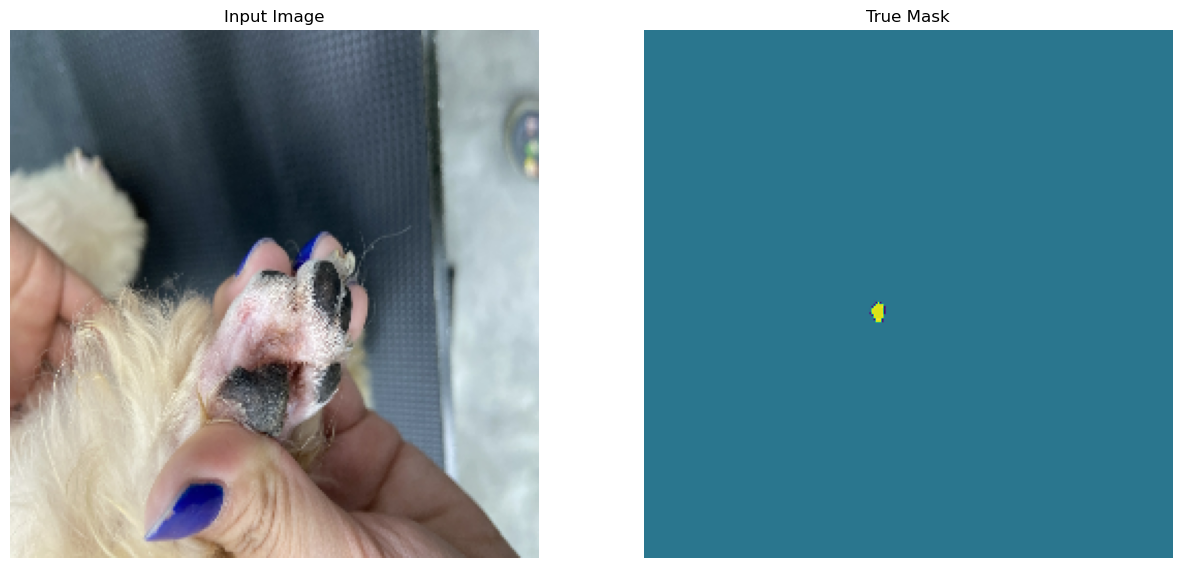

In [53]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드 함수 정의
def parse_tfrecord_fn(example):
    feature_description = {
        'Raw_data_ID': tf.io.FixedLenFeature([], tf.string),
        'img_path': tf.io.FixedLenFeature([], tf.string),
        'lesions': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    img_path = tf.strings.join([example['img_path'], tf.constant('/'), example['Raw_data_ID']])
    lesions = tf.strings.split(example['lesions'], ',')  # Split the lesions string

    # channel = 3 (RGB)
    img = tf.io.decode_png(tf.io.read_file(img_path), channels=3)

    # Create mask paths using tf.map_fn
    mask_paths = tf.map_fn(lambda lesion: tf.strings.regex_replace(img_path, 'images', f'train_true_mask_images_{lesion}'), lesions, dtype=tf.string)
    mask_paths = tf.strings.join(['./train_segmentation_mask_images_', lesions, '/mask_', example['Raw_data_ID']])

    # Read and decode masks
    masks = tf.map_fn(lambda mask_path: tf.io.decode_png(tf.io.read_file(mask_path), channels=1), mask_paths, dtype=tf.uint8)

    # Combine masks into a single mask (assuming multiple lesions)
    combined_mask = tf.reduce_max(masks, axis=0)  # Combine masks by taking the maximum value at each pixel

    return img, combined_mask

# TFRecord 파일 리스트
tfrecord_files = './train_symptoms_tfrecords/train_symptoms_A1.tfrecord'
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(parse_tfrecord_fn)

def prepare_dataset(dataset, batch_size=2, target_size=(256, 256)):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    def resize_image(image, mask):
        image = tf.image.resize(image, target_size)
        mask = tf.image.resize(mask, target_size, method='nearest')
        mask = tf.cast(mask, tf.float32) / 255.0  # Normalize mask to range [0, 1]
        mask = tf.expand_dims(mask, axis=-1)  # Add channel dimension to mask
        return image, mask

    dataset = dataset.map(resize_image)
    
    return dataset

# 데이터셋 준비
sampled_dataset = dataset.take(100)
train_dataset = prepare_dataset(sampled_dataset)


# 데이터셋 시각화
def display_sample(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i][0]))  # 배치 차원 제거
        else:
            mask = tf.squeeze(display_list[i][0], axis=-1)  # 배치 차원 제거 및 마스크의 채널 축 제거
            plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
        plt.axis('off')
    plt.show()

for image, mask in train_dataset.take(2):
    sample_image, sample_mask = image[0][tf.newaxis, ...], mask[0][tf.newaxis, ...]
    display_sample([sample_image, sample_mask])


In [13]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# def unet_model(input_size=(256, 256, 3)):
#     inputs = layers.Input(input_size)
    
#     # U-Net encoder
#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
#     pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
#     drop4 = layers.Dropout(0.5)(conv4)
#     pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
#     conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
#     drop5 = layers.Dropout(0.5)(conv5)

#     # U-Net decoder
#     up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(drop5))
#     merge6 = layers.concatenate([drop4, up6], axis=3)
#     conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
#     conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

#     up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
#     merge7 = layers.concatenate([conv3, up7], axis=3)
#     conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
#     conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

#     up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
#     merge8 = layers.concatenate([conv2, up8], axis=3)
#     conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
#     conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

#     up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
#     merge9 = layers.concatenate([conv1, up9], axis=3)
#     conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
#     conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
#     conv9 = layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
#     conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

#     model = models.Model(inputs=inputs, outputs=conv10)

#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# unet = unet_model()




# from tensorflow.keras.applications import ResNet50

# def resnet_modified(input_shape=(256, 256, 3)):
#     base_model = ResNet50(include_top=False, input_shape=input_shape)
#     base_model.trainable = False
    
#     inputs = layers.Input(shape=input_shape)
#     x = base_model(inputs, training=False)
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(1024, activation='relu')(x)
#     x = layers.Dense(512, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)
    
#     model = models.Model(inputs, outputs)
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# resnet = resnet_modified()




## end-to-end로 연결

## 수정된 U-Net model (tensorflow 참고)

In [2]:
# !pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\아경\appdata\local\temp\pip-req-build-32kzk77o
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=303791 sha256=484ef8f421dac95adf4a841a49f7e91db6bb9a2245cd0d896d1c9a730187ffaf
  Stored in directory: C:\Users\아경\AppData\Local\Temp\pip-ephem-wheel-cache-qiswbeeb\wheels\91\9b\e8\6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\아경\AppData\Local\Temp\pip-req-build-32kzk77o'


In [44]:
import tensorflow as tf
# import tensorflow_examples
# from tensorflow_examples.models import pix2pix
from pix2pix import pix2pix

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.metrics import IoU

from IPython.display import clear_output
import matplotlib.pyplot as plt

# U-Net 모델 정의 및 학습
# (코드 생략)
########################################################################

# 수정된 U-Net 사용
# MobileNet V2를 인코더 --> pix2pix 예제에서 이미 구현된 업샘플 블록 사용
unet_base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project',     # 4x4
]

unet_base_model_output = [unet_base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=unet_base_model.input, outputs=unet_base_model_output)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding='same')  # 64x64 -> 128x128
    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)



In [45]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_9 (Functional)        [(None, 64, 64, 96),         1841984   ['input_13[0][0]']            
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                           

In [ ]:
## ResNet 50 모델 (추 후에 end-to-end 연결)

In [ ]:

# ResNet50 모델 정의 및 학습
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 피부 질환 분류를 위한 FC 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10)

# 엔드투엔드 모델 정의
input_img = Input(shape=(None, None, 3))
segmented_img = unet_model(input_img)  # U-Net 모델 출력
classification = resnet50_model(segmented_img)  # ResNet50 모델 출력

end_to_end_model = Model(inputs=input_img, outputs=classification)

# 새로운 입력 이미지에 대한 예측
new_image = ...  # 새로운 입력 이미지 로드
prediction = end_to_end_model.predict(new_image)

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from pix2pix import pix2pix

# 데이터 로드 함수 정의
def parse_tfrecord_fn(example):
    feature_description = {
        'Raw_data_ID': tf.io.FixedLenFeature([], tf.string),
        'img_path': tf.io.FixedLenFeature([], tf.string),
        'lesions': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    img_path = tf.strings.join([example['img_path'], tf.constant('/'), example['Raw_data_ID']])
    lesions = tf.strings.split(example['lesions'], ',')  # Split the lesions string

    # channel = 3 (RGB)
    img = tf.io.decode_png(tf.io.read_file(img_path), channels=3)

    # Create mask paths using tf.map_fn
    mask_paths = tf.map_fn(lambda lesion: tf.strings.regex_replace(img_path, 'images', f'train_true_mask_images_{lesion}'), lesions, dtype=tf.string)
    mask_paths = tf.strings.join(['./train_segmentation_mask_images_', lesions, '/mask_', example['Raw_data_ID']])

    # Read and decode masks
    masks = tf.map_fn(lambda mask_path: tf.io.decode_png(tf.io.read_file(mask_path), channels=1), mask_paths, dtype=tf.uint8)

    # Combine masks into a single mask (assuming multiple lesions)
    combined_mask = tf.reduce_max(masks, axis=0)

    return img, combined_mask

# TFRecord 파일 리스트
tfrecord_files = './train_symptoms_tfrecords/train_symptoms_A1.tfrecord'
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(parse_tfrecord_fn)

def prepare_dataset(dataset, batch_size=2, target_size=(256, 256)):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    def resize_image(image, mask):
        image = tf.image.resize(image, target_size)
        mask = tf.image.resize(mask, target_size, method='nearest')
        mask = tf.cast(mask, tf.float32) / 255.0  # Normalize mask to range [0, 1]
        mask = tf.expand_dims(mask, axis=-1)  # Add channel dimension to mask
        return image, mask

    dataset = dataset.map(resize_image)
    return dataset

# 데이터셋 준비
sampled_dataset = dataset.take(100)
train_dataset = prepare_dataset(sampled_dataset)


In [52]:
from tensorflow.keras.metrics import MeanIoU

# U-Net 모델 정의 및 학습
unet_model = unet_model(output_channels=3)  # 출력 채널 수를 3로 설정
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2, name='IoU', target_class_ids=[1])])
unet_model.fit(train_dataset, epochs=10)

# ResNet50 모델 정의 및 학습
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
num_classes = 3  # 예시로 3개 클래스 가정
predictions = Dense(num_classes, activation='softmax')(x)
resnet50_model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일 및 학습
resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 엔드투엔드 모델 정의
input_img = Input(shape=(None, None, 3))
segmented_img = unet_model(input_img)  # U-Net 모델 출력
segmented_img = tf.cast(segmented_img > 0.5, tf.float32)  # Binary mask
classification = resnet50_model(segmented_img)  # ResNet50 모델 출력
end_to_end_model = Model(inputs=input_img, outputs=classification)

ValueError: The first argument to `Layer.call` must always be passed.

In [2]:
from tensorflow.keras.layers import Conv2DTranspose, Concatenate

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding='same')  # 64x64 -> 128x128
    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

unet_base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project',     # 4x4
]
unet_base_model_output = [unet_base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=unet_base_model.input, outputs=unet_base_model_output)
down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

unet = unet_model(output_channels=3)  # 3 output channels for the segmentation classes
unet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train U-Net model
# unet.fit(train_dataset, epochs=1)


# 이거

1/1 [==============================] - 2s 2s/step


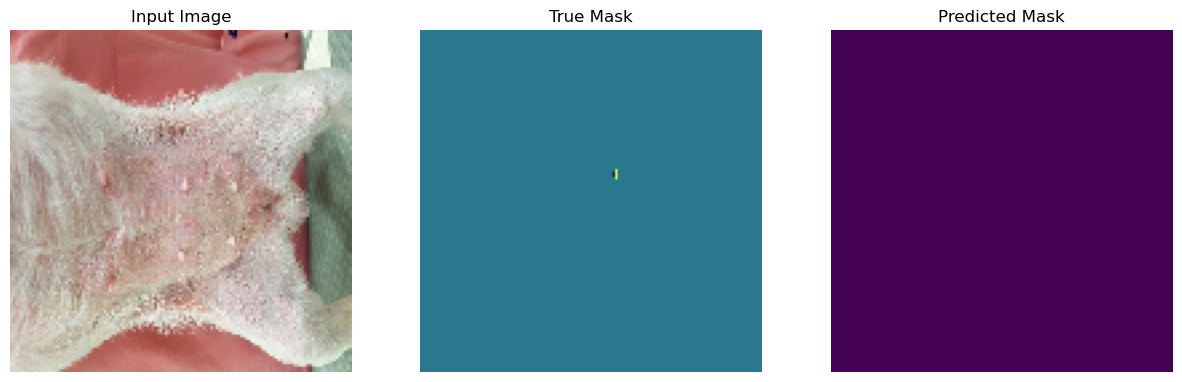

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from pix2pix import pix2pix

# 데이터 로드 함수 정의
def parse_tfrecord_fn(example):
    feature_description = {
        'Raw_data_ID': tf.io.FixedLenFeature([], tf.string),
        'img_path': tf.io.FixedLenFeature([], tf.string),
        'lesions': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    img_path = tf.strings.join([example['img_path'], tf.constant('/'), example['Raw_data_ID']])
    lesions = tf.strings.split(example['lesions'], ',')  # Split the lesions string

    # Load and decode the image
    img = tf.io.decode_png(tf.io.read_file(img_path), channels=3)

    # Create mask paths using tf.map_fn
    mask_paths = tf.map_fn(lambda lesion: tf.strings.regex_replace(img_path, 'images', f'train_true_mask_images_{lesion}'), lesions, dtype=tf.string)
    mask_paths = tf.strings.join(['./train_segmentation_mask_images_', lesions, '/mask_', example['Raw_data_ID']])

    # Read and decode masks
    masks = tf.map_fn(lambda mask_path: tf.io.decode_png(tf.io.read_file(mask_path), channels=1), mask_paths, dtype=tf.uint8)

    # Combine masks into a single mask (assuming multiple lesions)
    combined_mask = tf.reduce_max(masks, axis=0)

    return img, combined_mask

# TFRecord 파일 리스트
tfrecord_files = './train_symptoms_tfrecords/train_symptoms_A1.tfrecord'
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(parse_tfrecord_fn)

def prepare_dataset(dataset, batch_size=2, target_size=(128, 128)):  # Update target_size
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    def resize_image(image, mask):
        image = tf.image.resize(image, target_size)  # Resize image to target_size
        mask = tf.image.resize(mask, target_size, method='nearest')
        mask = tf.cast(mask, tf.float32) / 255.0  # Normalize mask to range [0, 1]
        mask = tf.expand_dims(mask, axis=-1)  # Add channel dimension to mask
        return image, mask

    dataset = dataset.map(resize_image)
    return dataset

# 데이터셋 준비
sampled_dataset = dataset.take(1000)
train_dataset = prepare_dataset(sampled_dataset, batch_size=32)

def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        img = tf.squeeze(display_list[i])
        if len(img.shape) == 2:  # If the image is grayscale, add a channel dimension
            img = tf.expand_dims(img, axis=-1)
        plt.imshow(tf.keras.utils.array_to_img(img))
        plt.axis('off')
    plt.show()

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

# Call show_predictions to display images
show_predictions(train_dataset, num=1)


1/1 [==============================] - 0s 37ms/step


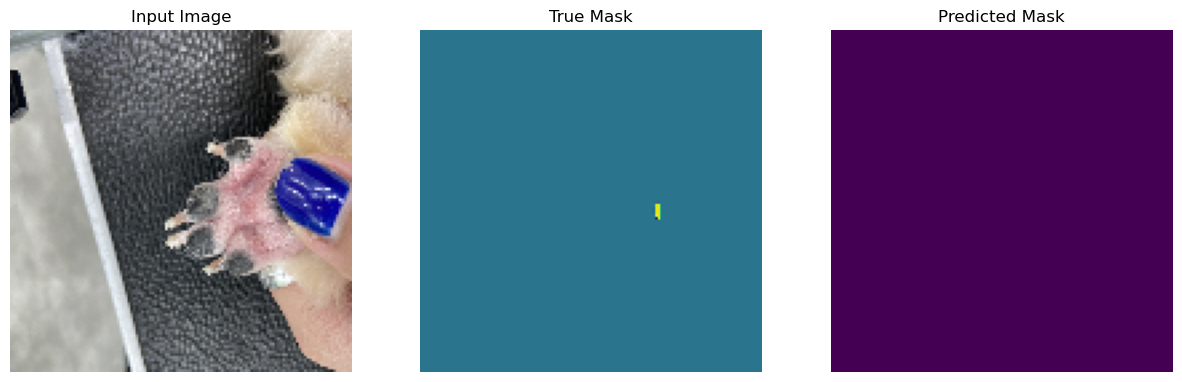


Sample Prediction after epoch 20

16/16 [==============================] - 19s 1s/step - loss: 1.3016e-06 - accuracy: 0.0000e+00


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from pix2pix import pix2pix
from IPython.display import clear_output

# 데이터 로드 함수 정의
def parse_tfrecord_fn(example):
    feature_description = {
        'Raw_data_ID': tf.io.FixedLenFeature([], tf.string),
        'img_path': tf.io.FixedLenFeature([], tf.string),
        'lesions': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    img_path = tf.strings.join([example['img_path'], tf.constant('/'), example['Raw_data_ID']])
    lesions = tf.strings.split(example['lesions'], ',')  # Split the lesions string

    # Load and decode the image
    img = tf.io.decode_png(tf.io.read_file(img_path), channels=3)

    # Create mask paths using tf.map_fn
    mask_paths = tf.map_fn(lambda lesion: tf.strings.regex_replace(img_path, 'images', f'train_true_mask_images_{lesion}'), lesions, dtype=tf.string)
    mask_paths = tf.strings.join(['./train_segmentation_mask_images_', lesions, '/mask_', example['Raw_data_ID']])

    # Read and decode masks
    masks = tf.map_fn(lambda mask_path: tf.io.decode_png(tf.io.read_file(mask_path), channels=1), mask_paths, dtype=tf.uint8)

    # Combine masks into a single mask (assuming multiple lesions)
    combined_mask = tf.reduce_max(masks, axis=0)

    return img, combined_mask

# TFRecord 파일 리스트
tfrecord_files = './train_symptoms_tfrecords/train_symptoms_A1.tfrecord'
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(parse_tfrecord_fn)

def prepare_dataset(dataset, batch_size=64, target_size=(128, 128)):  # Update target_size
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    def resize_image(image, mask):
        image = tf.image.resize(image, target_size)  # Resize image to target_size
        mask = tf.image.resize(mask, target_size, method='nearest')
        mask = tf.cast(mask, tf.float32) / 255.0  # Normalize mask to range [0, 1]
        mask = tf.expand_dims(mask, axis=-1)  # Add channel dimension to mask
        return image, mask

    dataset = dataset.map(resize_image)
    return dataset

# 데이터셋 준비
sampled_dataset = dataset.take(1000)
train_dataset = prepare_dataset(sampled_dataset, batch_size=64)

def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        img = tf.squeeze(display_list[i])
        if len(img.shape) == 2:  # If the image is grayscale, add a channel dimension
            img = tf.expand_dims(img, axis=-1)
        plt.imshow(tf.keras.utils.array_to_img(img))
        plt.axis('off')
    plt.show()

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

    else:
        display([sample_image, sample_mask, create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

# 콜백 클래스 정의
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)

        # show_predictions(train_dataset, num=1)

        show_predictions() # sample image 만 보기 위해
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

# UNet 모델 정의 및 컴파일
unet_base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project',     # 4x4
]
unet_base_model_output = [unet_base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=unet_base_model.input, outputs=unet_base_model_output)
down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding='same')  # 64x64 -> 128x128
    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

for images, masks in train_dataset.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])


unet = unet_model(output_channels=3)  # 3 output channels for the segmentation classes
unet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train U-Net model with DisplayCallback
EPOCHS = 20
unet.fit(train_dataset, epochs=EPOCHS, callbacks=[DisplayCallback()])


In [58]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
num_classes = 6  # Number of classes for classification
predictions = Dense(num_classes, activation='softmax')(x)
resnet50_model = Model(inputs=base_model.input, outputs=predictions)

# Compile ResNet50 model
resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [60]:
input_img = Input(shape=(256, 256, 3))
segmented_img = unet(input_img)  # U-Net model output

# Resize the segmented image to the input size expected by ResNet50
segmented_img_resized = tf.image.resize(segmented_img, (224, 224))
segmented_img_resized = tf.cast(segmented_img_resized > 0.5, tf.float32)  # Binarize the mask

classification = resnet50_model(segmented_img_resized)  # ResNet50 model output
end_to_end_model = Model(inputs=input_img, outputs=classification)

# Compile the end-to-end model
end_to_end_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
end_to_end_model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 model_17 (Functional)       (None, 256, 256, 3)       6504227   
                                                                 
 tf.image.resize_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.greater_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 model_18 (Functional)       (None, 6)                 256